# Short Text Clustering

In [1]:
%load_ext autoreload
%autoreload 2

The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

<br>
Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

In [2]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from utils.embedding import Embeddor

%matplotlib inline

Using TensorFlow backend.


In [3]:
EMBDIR = "./embeddings/"
DATADIR = "./data/short_texts/"

print('\nShort text datasets')
pprint(os.listdir(DATADIR))

print('\nEmbedding')
pprint(os.listdir(EMBDIR))


Short text datasets
['SearchSnippets_gnd.txt',
 'Biomedical_gnd.txt',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt',
 'Biomedical.txt',
 'labels.tsv',
 'SearchSnippets.txt']

Embedding
['glove100K.100d.vec', 'fasttext.wiki.en.vec']


# Fetching the data

#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for English languages, trained on Wikipedia using fastText. These vectors of dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words.

# Word embedding

In [4]:
# parameters
n_emb = int(3 * 1e5)
emb_name = 'fasttext.wiki.en.vec'
print("Embedding: %s" % emb_name)
src_emb = os.path.join(EMBDIR, emb_name)

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))

Embedding: fasttext.wiki.en.vec


Widget Javascript not detected.  It may not be installed or enabled properly.



Embedding shape: (300001, 300)


In [5]:
embeddor.most_similar('napoleon')

[('napoleon', 0.99999964),
 ('napoleons', 0.79422355),
 ('bonaparte', 0.77908498),
 ('napoléon', 0.71624726),
 ('napoleonic', 0.69677401),
 ('napoleone', 0.69525903),
 ('bonapartist', 0.68990511),
 ('bonapartists', 0.67171675),
 ('davout', 0.66151792),
 ('buonaparte', 0.6598503)]

# Load text data

#### Loading data

In [6]:
#DATA = "Biomedical"
#DATA = "SearchSnippets"
DATA = "StackOverflow"

text_path = os.path.join(DATADIR, '%s.txt' % DATA)
with open(text_path, encoding="utf-8") as f:
    data = f.readlines()

label_path = os.path.join(DATADIR, '%s_gnd.txt' % DATA)
with open(label_path, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("Total: %s short texts" % format(len(data), ","))

Total: 20,000 short texts


#### Random samples

In [7]:
n = len(data)
sample = 10000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 10,000 samples


#### Tokenize

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(data)
sequences_full = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
MAX_NB_WORDS = len(word_index)

seq_lens = [len(s) for s in sequences_full]
print("Average length: %d" % np.mean(seq_lens))
print("Max length: %d" % max(seq_lens))
MAX_SEQUENCE_LENGTH = max(seq_lens)

X = pad_sequences(sequences_full, maxlen=MAX_SEQUENCE_LENGTH)
y = target
tfidf = tokenizer.sequences_to_matrix(sequences_full, mode='tfidf')

Found 6945 unique tokens.
Average length: 8
Max length: 34


# Getting sequences and targets

In [9]:
# creating embedding matrix
EMBEDDING_DIM = embeddor.emb_dim
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding = embeddor.get_emb(word)
    if embedding is not None:
        embedding_matrix[i] = embedding
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 4986 words in the embedding matrix


# Target vectors 

In [10]:
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.target import laplacian_eigenmaps, binarize

# dictionary containing all target vectors
Y = dict()

#### Average embeddings (AE)

In [11]:
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)

Shape of average embedding:  (10000, 300)
CPU times: user 2.48 s, sys: 94 ms, total: 2.57 s
Wall time: 389 ms


#### Latent Semantic Analysis (LSA)

In [12]:
%%time
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
L = lsa.fit_transform(tfidf)
Y["lsa"] = L
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (10000, 100)
CPU times: user 21.3 s, sys: 311 ms, total: 21.6 s
Wall time: 1.54 s


#### Laplacian Eigenmaps (LE) [memory intensive]

In [13]:
%%time
# eigen vectors from graph of text similarity
E = laplacian_eigenmaps(L, n_neighbors=15, subdim=15, n_jobs=-1)
Y["le"] = E
print(E.shape)

Fitting nearest neighbors
Creation of heat kernel affinity matrix
Spectral embedding
(10000, 15)
CPU times: user 5min 49s, sys: 2.31 s, total: 5min 51s
Wall time: 34.5 s


#### Binarize target vector

In [14]:
reduction_name = "le"
B = binarize(Y[reduction_name])

# Last dimension in the CNN
TARGET_DIM = B.shape[1]

# Example of binarized target vector
print(B.shape)
print(B[0])

(10000, 15)
[ 0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.]


# CNN for deep feature representation learning 

In [15]:
from keras.layers import Input, Embedding, Flatten, Reshape
from keras.layers import Dense, Conv1D, Dropout, merge
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, ZeroPadding1D
from keras.models import Model

embedding_matrix_copy = embedding_matrix.copy()
trainable_embedding = False

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# 1st Layer
x = Conv1D(100, 5, activation='tanh', padding='same')(embedded_sequences)
x = GlobalMaxPooling1D()(x)

# Output
x = Dropout(0.5)(x)
predictions = Dense(TARGET_DIM, activation='sigmoid')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_embedding

# Loss and Optimizer
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 300)           2083800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 100)           150100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1515      
Total params: 2,235,415
Trainable params: 151,615
Non-trainable params: 2,083,800
____________________________________________________________

In [16]:
%%time
nb_epoch = 1
model.fit(X, B, validation_split=0.2,
          epochs=nb_epoch, batch_size=100, verbose=2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/1
2s - loss: 0.6429 - mean_absolute_error: 0.4617 - val_loss: 0.5946 - val_mean_absolute_error: 0.4349
CPU times: user 18.5 s, sys: 2.8 s, total: 21.3 s
Wall time: 2.53 s


#### Deep feature representations h

In [17]:
from keras.models import Model

# create model that gives penultimate layer
input = model.layers[0].input
output = model.layers[-2].output
model_penultimate = Model(input, output)

# inference of penultimate layer
H = model_penultimate.predict(X)

In [18]:
print("Sample shape: {}".format(H.shape))

Sample shape: (10000, 100)


# Tools for evaluating cluster quality

# K-means 

In [19]:
from utils.metrics import map_label, cluster_quality
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

true_labels = y
n_clusters = len(np.unique(y))
print("Number of classes: %d" % n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=10)
result = dict()
pred = dict()

Number of classes: 20


#### Deep feature representation

In [20]:
%%time
V = normalize(H, norm='l2')
km.fit(V)
pred['deep'] = km.labels_
result['deep'] = cluster_quality(true_labels, pred['deep'])

Homogeneity: 0.635
Completeness: 0.670
V-measure: 0.652
NMI: 0.652
Rand score: 0.443
Accuracy: 0.653
CPU times: user 205 ms, sys: 112 ms, total: 317 ms
Wall time: 1.15 s


#### LSA

In [21]:
%%time
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tfidf)
LSA = normalize(LSA)
km.fit(LSA)
pred['lsa'] = km.labels_
result['lsa'] = cluster_quality(true_labels, pred['lsa'])

Homogeneity: 0.607
Completeness: 0.664
V-measure: 0.634
NMI: 0.635
Rand score: 0.326
Accuracy: 0.649
CPU times: user 23.6 s, sys: 1.05 s, total: 24.6 s
Wall time: 3.62 s


#### Laplacian eigenvalues

In [22]:
%%time
NB = normalize(Y["le"])
km.fit(NB)
pred['eigen'] = km.labels_
result['eigen'] = cluster_quality(true_labels, pred['eigen'])

Homogeneity: 0.523
Completeness: 0.535
V-measure: 0.529
NMI: 0.529
Rand score: 0.440
Accuracy: 0.632
CPU times: user 175 ms, sys: 119 ms, total: 294 ms
Wall time: 878 ms


# Cluster visualization

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from webcolors import name_to_rgb
from sklearn.manifold import TSNE

color_names = ['SeaGreen', 'Sienna', 'Silver', 'Navy', 'Purple', 'SlateGrey', 'Orange',
               'SpringGreen', 'SteelBlue', 'Lime', 'Teal', 'Thistle', 'Tomato', 'Turquoise',
               'Violet', 'OrangeRed', 'Black', 'Red', 'Yellow', 'YellowGreen']

# number of samples to visualize because tsne is slow
n_sample = 1000
index_sample = np.random.randint(low=0, high=sample, size=(n_sample,))

# mapping color to sample
labels = np.unique(y)
colormap = {label: color for label, color in zip(labels, color_names)}
colors = [colormap[x] for x in true_labels]
color_rgb = [name_to_rgb(name) for name in colors]
color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
color_sample = [color_rgb_norm[idx] for idx in index_sample]

# plot function
def plot_tsne(T, color):
    plt.figure(figsize=(10, 10))
    plt.scatter(T[:, 0], T[:, 1], c=color, s=30)

#### t-SNE embedding on deep feature representations

<br>
Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [24]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, 
            early_exaggeration=4.,
            learning_rate=1000,
            init="pca", 
            metric="euclidean")

#### t-SNE on Deep feature representation

In [25]:
%%time
deep_feature = V[index_sample]
tsne_deep = tsne.fit_transform(deep_feature)

CPU times: user 19.9 s, sys: 1.51 s, total: 21.4 s
Wall time: 18.4 s


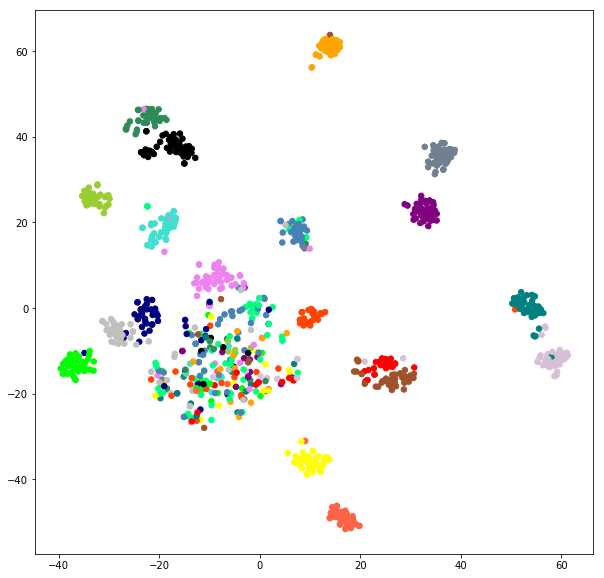

In [26]:
plot_tsne(tsne_deep, color=color_sample)

#### t-SNE embedding on LSA

In [27]:
%%time
tsne_lsa = tsne.fit_transform(LSA[index_sample])

CPU times: user 20 s, sys: 1.7 s, total: 21.7 s
Wall time: 18.7 s


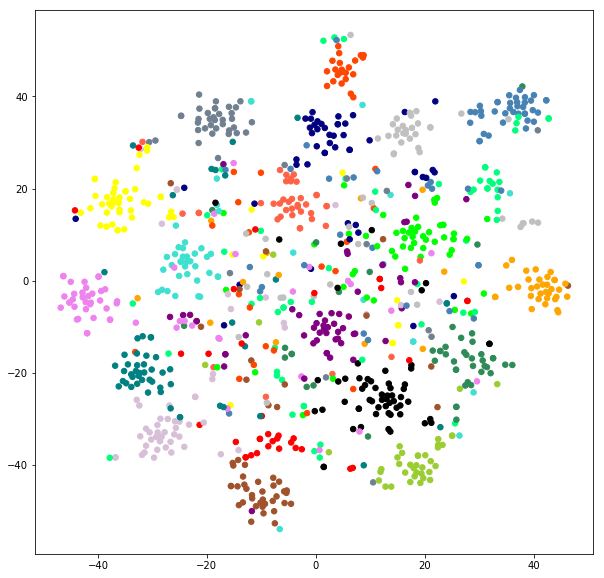

In [28]:
plot_tsne(tsne_lsa, color=color_sample)

#### t-SNE on Laplacian eigenvalues

In [29]:
%%time
le = Y["le"]
tsne_le = tsne.fit_transform(le[index_sample])

CPU times: user 22.6 s, sys: 1.74 s, total: 24.3 s
Wall time: 21.5 s


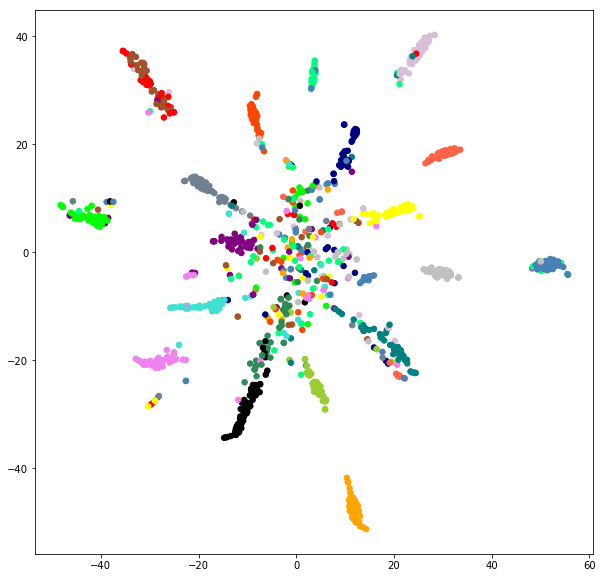

In [30]:
plot_tsne(tsne_le, color=color_sample)